# Understanding and Predicting Tenure
Dataset from Kaggle : **"Telco Customer Churn"** by *BLASTCHAR*  
Source: https://www.kaggle.com/datasets/blastchar/telco-customer-churn (requires login)



### Imported Libraries
> NumPy : Library for Numeric Computations in Python  
> Pandas : Library for Data Acquisition and Preparation  
> Matplotlib : Low-level library for Data Visualization  
> Seaborn : Higher-level library for Data Visualization  

> LabelEncoder, OneHotEncoder : Changing categorical data to numerical


> train_test_split : Randomly split the dataset to pass to the machine learning models


> r2_score : Find the Variance

> mean_squared_error : Find the MSE

> LinearRegression, DecisionTreeRegressor, GradientBoostingRegressor, RandomForestRegressor : Scikit-Learn Machine Learning Models

> XGBRegressor : xgboost Machine Learning Model

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

sb.set() # set the default Seaborn style for graphics

### Import the Dataset

The dataset is in CSV format; hence we use the `read_csv` function from Pandas.  
Immediately after importing, take a quick look at the data using the `head` function.

In [2]:
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Data Prepping Section

In [3]:
# Removing the empty rows in the TotalCharges Collumn
data = data[data['TotalCharges'].str.strip().astype(bool)]

In [4]:
# Creating the concatenated numerical data
num = data[["TotalCharges","MonthlyCharges"]]
num = num.astype('float64')

In [5]:
# Quickly checking the num dataset
num

,TotalCharges,MonthlyCharges
0,29.85,29.85
1,1889.50,56.95
2,108.15,53.85
3,1840.75,42.30
4,151.65,70.70
...,...,...
7038,1990.50,84.80
7039,7362.90,103.20
7040,346.45,29.60
7041,306.60,74.40


<AxesSubplot:xlabel='MonthlyCharges'>

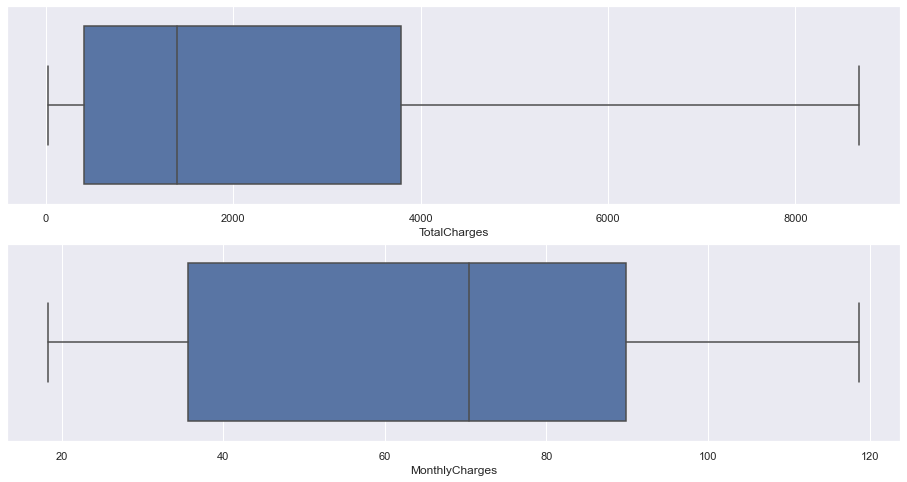

In [6]:
# Draw the boxplots to analyze the numerical data set before removing outliers
f, axes = plt.subplots(2, 1, figsize=(16, 8))

sb.boxplot(x = num["TotalCharges"], orient = "h", ax = axes[0])
sb.boxplot(x = num["MonthlyCharges"], orient = "h", ax = axes[1])

### Removing Outliers

We use IQR to find the outliers.
Then we find the index of the outliers and use that to drop the outlier from the num dataset

In [7]:
# Calculate the quartiles
Q1 = num.quantile(0.25)
Q3 = num.quantile(0.75)

# Rule to identify outliers
rule = ((num < (Q1 - 1.5 * (Q3 - Q1))) | (num > (Q3 + 1.5 * (Q3 - Q1))))

# Identifyin the outliers
outliers = rule.any(axis = 1)
outlierindices = outliers.index[outliers == True]

# Removing the outliers
num.drop(axis = 0,               # 0 drops row 1 drops column
                index = outlierindices, # this takes a list as input
                inplace = True)         # not overwritten by default 

# Check the clean data
num

,TotalCharges,MonthlyCharges
0,29.85,29.85
1,1889.50,56.95
2,108.15,53.85
3,1840.75,42.30
4,151.65,70.70
...,...,...
7038,1990.50,84.80
7039,7362.90,103.20
7040,346.45,29.60
7041,306.60,74.40


In [8]:
# Creating the Concatenated Categorical dataset
cat = data[["DeviceProtection","OnlineSecurity","Partner","OnlineBackup"]]

In [9]:
# Convert the categorical dataset to numerical
cat = cat.apply(LabelEncoder().fit_transform)

In [10]:
# Combining both the selected categorical and the numerical dataset together
xvar = pd.concat([num,cat],axis=1)

In [11]:
# This is the value we want to study and predict
yvar = data[["tenure"]]

In [12]:
# Randomly split the dataset before fitting it into the different machine learning models
X_train, X_test, y_train, y_test = train_test_split(xvar, yvar, test_size = 0.3, random_state= 4)

In [13]:
# Quickly Checking the tenure
y_train.describe()

,tenure
count,4922.000000
mean,32.285859
std,24.612216
min,1.000000
25%,9.000000
50%,28.000000
75%,55.750000
max,72.000000


In [14]:
# Quickly checking the dataset that is to be fitted to the machine learning models
X_train

,TotalCharges,MonthlyCharges,DeviceProtection,OnlineSecurity,Partner,OnlineBackup
3483,1358.60,77.80,2,0,0,2
4754,1728.20,25.25,1,1,1,1
6145,3623.95,54.20,2,2,1,2
2202,467.55,70.10,0,0,1,0
3822,518.75,94.05,2,0,1,2
...,...,...,...,...,...,...
6026,232.10,19.45,1,1,0,1
710,19.55,19.55,1,1,0,1
2492,706.85,54.45,0,2,1,0
174,654.55,20.55,1,1,0,1


## Linear Regression Model

In [15]:
# Create a Linear Regression object
linreg = LinearRegression()

# Train the Linear Regression model
linreg.fit(X_train, y_train)

LinearRegression()

In [16]:
# Predict the Tenure values from Predictors
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

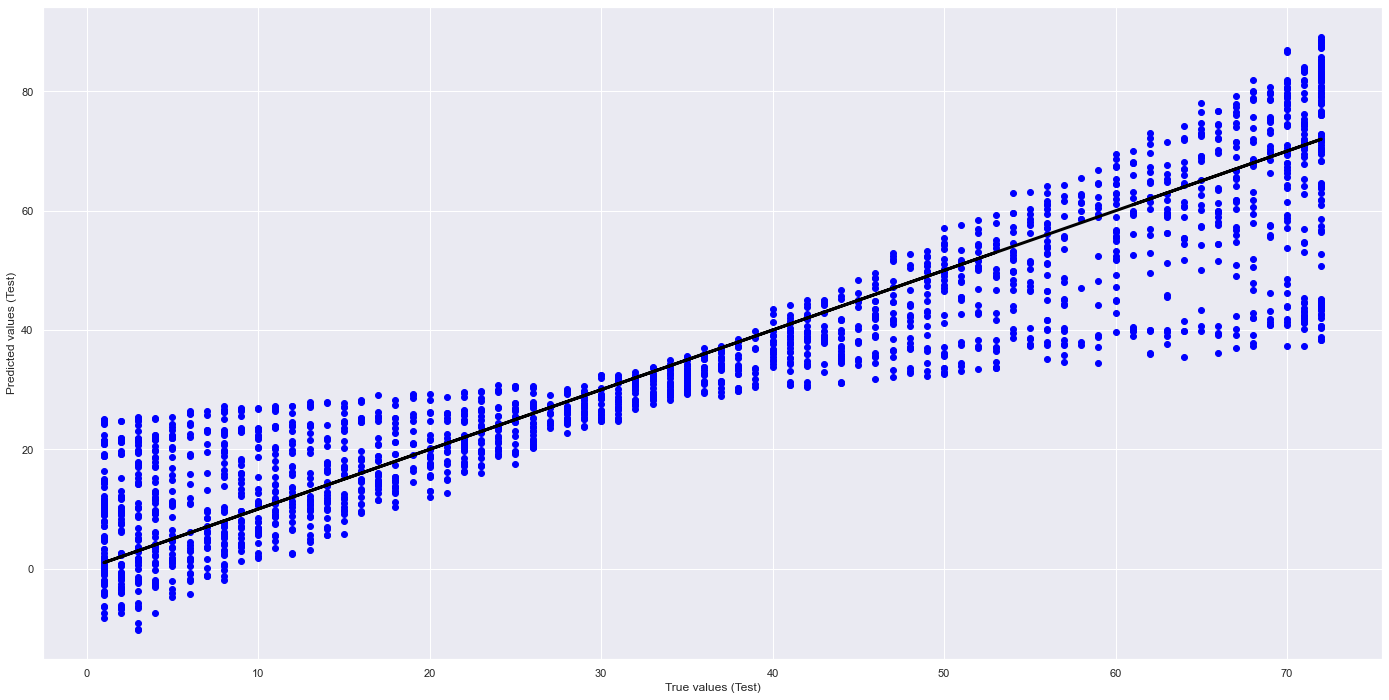

In [17]:
# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 1, figsize=(24, 12))
axes.scatter(y_test, y_test_pred, color = "blue")
axes.plot(y_test, y_test, 'black', linewidth = 3)
axes.set_xlabel("True values (Test)")
axes.set_ylabel("Predicted values (Test)")
plt.show()

In [18]:
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))

Mean Squared Error (MSE) 	: 101.10086556838978
Explained Variance (R^2) 	: 0.8299825162197527


## Decision Tree Regressor Model

In [19]:
# Create a Decision Tree Regressor object
tree = DecisionTreeRegressor( max_depth=4) 

# Train the Decision Tree Regressor model
tree.fit(X_train, y_train)

# Predict the Tenure values from Predictors
y_pred_t = tree.predict(X_test)

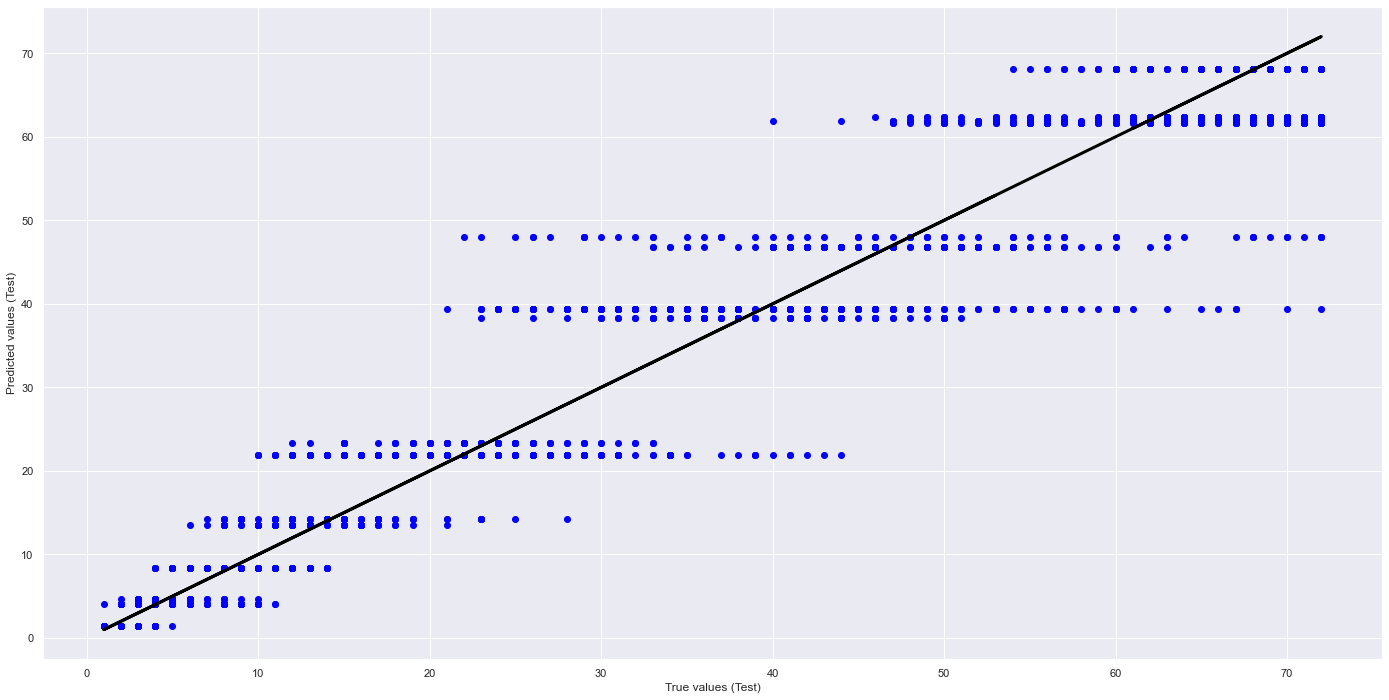

In [20]:
# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 1, figsize=(24, 12))
axes.scatter(y_test, y_pred_t, color = "blue")
axes.plot(y_test, y_test, 'black', linewidth = 3)
axes.set_xlabel("True values (Test)")
axes.set_ylabel("Predicted values (Test)")
plt.show()

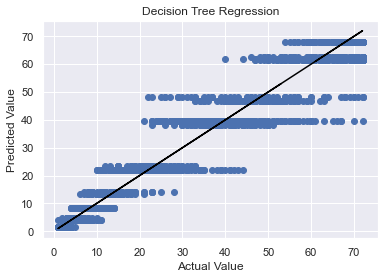

In [21]:
plt.scatter(y_test, y_pred_t)
plt.title("Decision Tree Regression")
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.plot(y_test,y_test,color = 'black')

In [22]:
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test,y_pred_t))
print("Explained Variance (R^2) \t:", tree.score(X_test,y_test))

Mean Squared Error (MSE) 	: 43.560155834047514
Explained Variance (R^2) 	: 0.9267465412255009


## Gradient Boosting Regressor Model

In [23]:
# Create a Gradient Boosting Regressor object
GBreg = GradientBoostingRegressor()

# Train the Gradient Boosting Regressor model
GBreg.fit(X_train,np.ravel(y_train))

GradientBoostingRegressor()

In [24]:
# Predict the Tenure values from Predictors
y_train_predGB = GBreg.predict(X_train)
y_test_predGB = GBreg.predict(X_test)

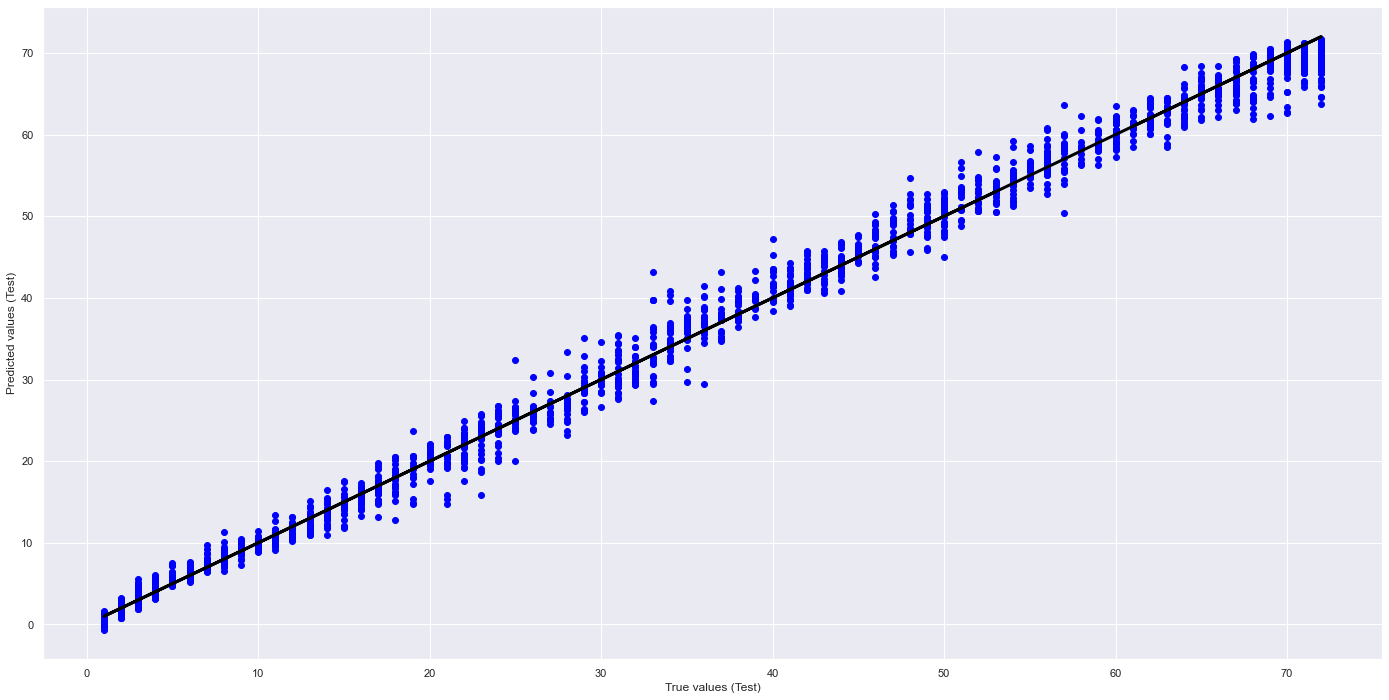

In [25]:
# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 1, figsize=(24, 12))
axes.scatter(y_test, y_test_predGB, color = "blue")
axes.plot(y_test, y_test, 'black', linewidth = 3)
axes.set_xlabel("True values (Test)")
axes.set_ylabel("Predicted values (Test)")
plt.show()

In [26]:
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_predGB))
print("Explained Variance (R^2) \t:", GBreg.score(X_train, y_train))

Mean Squared Error (MSE) 	: 2.571859786570847
Explained Variance (R^2) 	: 0.9957534710444484


In [27]:
# Focus on this value 
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_predGB))
print("Explained Variance (R^2) \t:", GBreg.score(X_test, y_test))

Mean Squared Error (MSE) 	: 3.1984829392425347
Explained Variance (R^2) 	: 0.9946212327838458


## Random Forest Regressor Model

In [28]:
# Create a Random Forest Regressor Object
regressor = RandomForestRegressor(n_estimators = 10, random_state = 4)

# Train the Random Forest Regressor Model
regressor.fit(X_train,y_train)

# Predict the Tenure values from Predictors
y_pred_f = regressor.predict(X_test)
r2_score(y_test, y_pred_f)

C:\Users\ahmad\AppData\Local\Temp/ipykernel_12768/2245937939.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(X_train,y_train)


0.9970709273544078

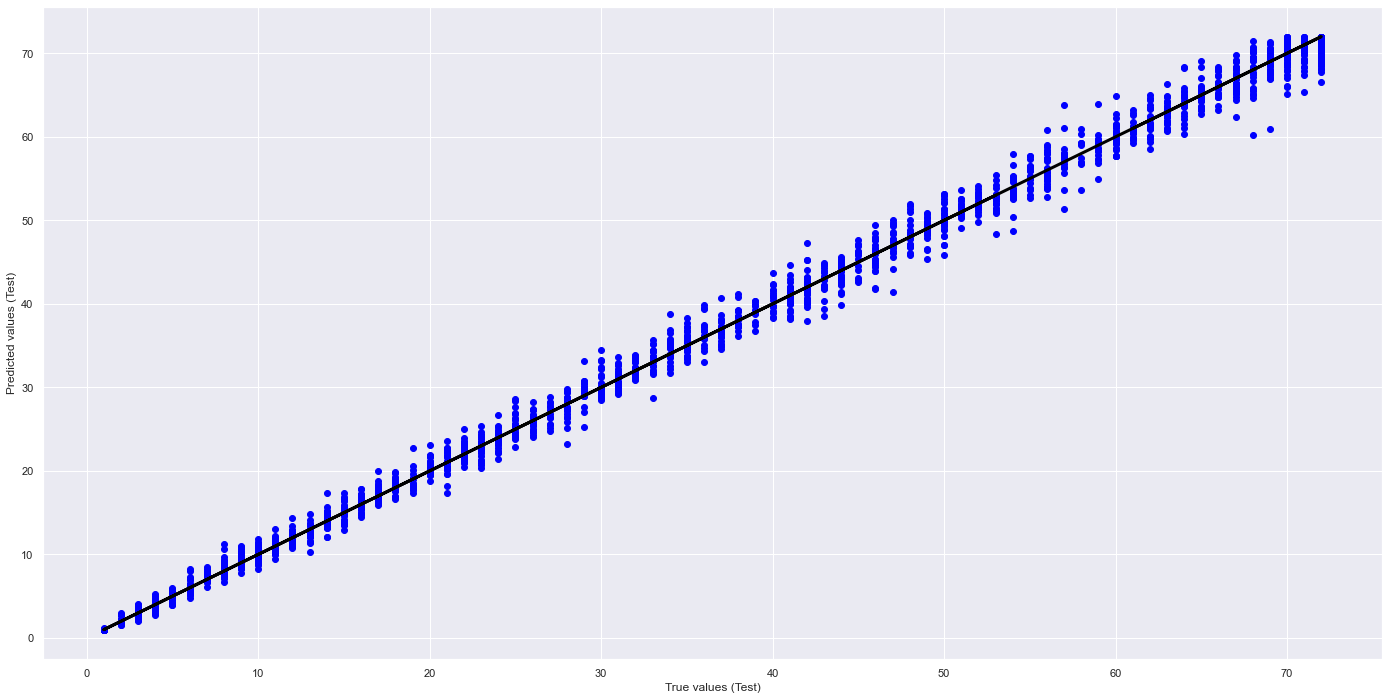

In [29]:
# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 1, figsize=(24, 12))
axes.scatter(y_test, y_pred_f, color = "blue")
axes.plot(y_test, y_test, 'black', linewidth = 3)
axes.set_xlabel("True values (Test)")
axes.set_ylabel("Predicted values (Test)")
plt.show()

In [30]:
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test,y_pred_f))
print("Explained Variance (R^2) \t:", regressor.score(X_test,y_test))

Mean Squared Error (MSE) 	: 1.7417725118483411
Explained Variance (R^2) 	: 0.9970709273544078


## XGBoost Regressor Model

In [31]:
# Create a XGBoost Regressor Object
xgmodel = XGBRegressor()

# Train the XGBoost Regressor Model
xgmodel.fit(X_train, y_train)

# Predict the Tenure value from predictors
yhat = xgmodel.predict(X_test)

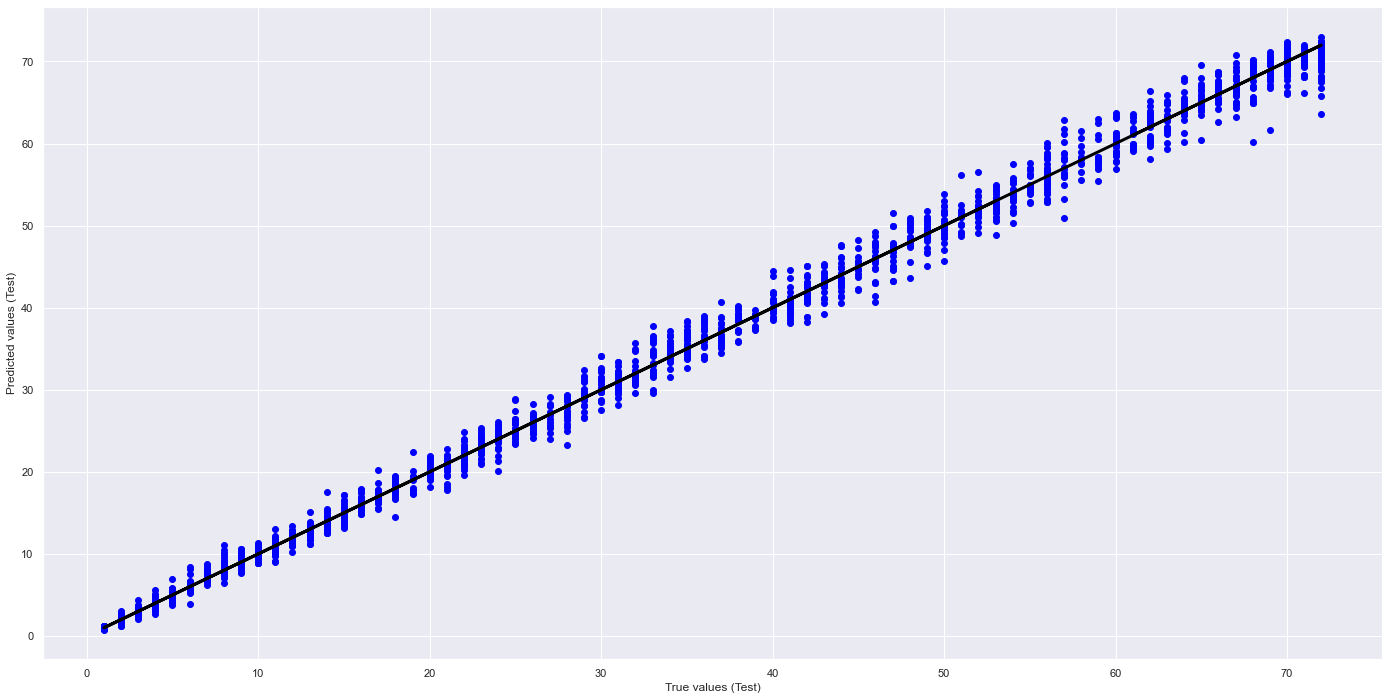

In [32]:
# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 1, figsize=(24, 12))
axes.scatter(y_test, yhat, color = "blue")
axes.plot(y_test, y_test, 'black', linewidth = 3)
axes.set_xlabel("True values (Test)")
axes.set_ylabel("Predicted values (Test)")
plt.show()

In [33]:
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test,yhat))
print("Explained Variance (R^2) \t:", xgmodel.score(X_test,y_test))

Mean Squared Error (MSE) 	: 1.894887945496348
Explained Variance (R^2) 	: 0.9968134389480485
